In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import settings.config as cfg

preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
group_sizes_to_create = cfg.group_sizes_to_create
group_similarity_to_create = cfg.group_similarity_to_create
group_number = cfg.group_number

print(group_number)

200


In [3]:
group_similarity_to_create

['COUNTER_EXAMPLE', 'SIMILAR']

In [4]:
preprocessed_dataset_folder

'preprocessed_dataset'

In [4]:
import pandas as pd

ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv") 
display(ratings_df.head(10))

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [5]:
# Load train test split (can be generated using training.ipynb)
import pickle
train_df = pickle.load(open(preprocessed_dataset_folder+"/train_df.pkl", "rb"))
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))

# Similarity evaluation

Evaluation of the similarity between all the pairs o users in the dataset.

In [6]:
# computing similarity between each pair of users

import numpy as np

user_matrix_full = ratings_df.pivot_table(columns='item', index='user', values='rating')
user_matrix_train = train_df.pivot_table(columns='item', index='user', values='rating')

user_id_set = set(ratings_df['user'])
user_id_indexes = user_matrix_full.index.values

user_matrix_full = user_matrix_full.fillna(0)
numpy_array = user_matrix_full.to_numpy()
sim_matrix_full = np.corrcoef(numpy_array)

arr = user_matrix_train.fillna(0).to_numpy()
sim_matrix_train = np.corrcoef(arr)


## Add similarity matrix based on matrix factorization features

In [7]:
from lenskit.algorithms.als import BiasedMF, ImplicitMF
from lenskit.algorithms import Recommender

In [8]:
# Load the algorithms (can be generated using training.ipynb)
recsys_biased_mf = pickle.load(open(preprocessed_dataset_folder+"/biasedMf.pkl", "rb"))
recsys_implicit_mf = pickle.load(open(preprocessed_dataset_folder+"/implicitMf.pkl", "rb"))

In [9]:
from scipy.spatial.distance import squareform, pdist

# The 1/1+x trick is used to get 1.0 on the diagonal and convert distance to similarity
sim_matrix_biased_mf_cos = (1/(1+squareform(pdist(recsys_biased_mf.predictor.user_features_, "cosine"))))
sim_matrix_biased_mf_l2 = (1/(1+squareform(pdist(recsys_biased_mf.predictor.user_features_, "euclidean"))))

sim_matrix_implicit_mf_cos = (1/(1+squareform(pdist(recsys_implicit_mf.predictor.user_features_, "cosine"))))
sim_matrix_implicit_mf_l2 = (1/(1+squareform(pdist(recsys_implicit_mf.predictor.user_features_, "euclidean"))))



In [10]:
### Plot correlation matrix
similarity_raw_to_name = {
    "Pearson's Correlation Coeficient FULL": "sim_full",
    "Pearson's Correlation Coeficient TRAIN": "sim_train",
    "Biased MF Cosine": "sim_biased_mf_cos",
    "Biased MF L2": "sim_biased_mf_l2",
    "Implicit MF Cosine": "sim_implicit_mf_cos",
    "Implicit MF L2": "sim_implicit_mf_l2"
}

group_compositions = {}
for sim_name in similarity_raw_to_name.values():
    group_compositions[sim_name] = pickle.load(open(preprocessed_dataset_folder+f"/group_composition_{sim_name}.pkl", "rb"))

In [11]:
metrics = {
    "sim_full": sim_matrix_full,
    "sim_train": sim_matrix_train,
    "sim_biased_mf_cos": sim_matrix_biased_mf_cos,
    "sim_biased_mf_l2": sim_matrix_biased_mf_l2,
    "sim_implicit_mf_cos": sim_matrix_implicit_mf_cos,
    "sim_implicit_mf_l2": sim_matrix_implicit_mf_l2
}

In [82]:
rename_d = {'sim_full': 'PCC_full',
 'sim_train': 'PCC_train',
 'sim_biased_mf_cos': 'COS_biasMF',
 'sim_biased_mf_l2': 'L2_biasMF',
 'sim_implicit_mf_cos': 'COS_implMF',
 'sim_implicit_mf_l2': 'L2_implMF'}

In [12]:
id_to_idx = {idd: idx for idx, idd in enumerate(user_id_indexes)}

In [85]:
import time
from synthetic_groups_generation.groups_generators import Outliers

outlier_similarities = {}

result_dataframes = {}

for source_metric in ["sim_full", "sim_train", "sim_biased_mf_cos", "sim_biased_mf_l2", "sim_implicit_mf_cos", "sim_implicit_mf_l2"]:

    outlier_similarities[source_metric] = {}
    grc = group_compositions[source_metric]
    
    target_metrics = ["sim_full", "sim_train", "sim_biased_mf_cos", "sim_biased_mf_l2", "sim_implicit_mf_cos", "sim_implicit_mf_l2"]
    df_result = pd.DataFrame(columns=target_metrics)
    
    for target_metric in target_metrics:
        start_time = time.perf_counter()
        outlier_similarities[source_metric][target_metric] = []
    
        sim = metrics[target_metric]
    
        for i in range(2400, 3600): # Take all similar_with_centered_outliers with all group sizes  #range(2400, 2600):
            grp = grc[i]
            grp_size = grp["group_size"]

            outs = Outliers.get_num_outliers(grp_size)

            outliers = grp["group_members"][:outs]
            not_outliers = grp["group_members"][outs:]

            for outlier in outliers:
                out_idx = id_to_idx[outlier]
                for non_out in not_outliers:
                    non_out_idx = id_to_idx[non_out]
                    outlier_similarities[source_metric][target_metric].append(sim[out_idx, non_out_idx])
                    
        df_result.loc[:, target_metric] = outlier_similarities[source_metric][target_metric]
        result_dataframes[source_metric] = df_result
        print(f"Single metric combination took: {time.perf_counter() - start_time}")
        

Single metric combination took: 0.25622130000010657
Single metric combination took: 0.14351179999903252
Single metric combination took: 0.1596179000007396
Single metric combination took: 0.20265160000053584
Single metric combination took: 0.15047779999986233
Single metric combination took: 0.14193859999977576
Single metric combination took: 0.2318502999987686
Single metric combination took: 0.16483420000076876
Single metric combination took: 0.14573290000043926
Single metric combination took: 0.13562670000101207
Single metric combination took: 0.13618159999896307
Single metric combination took: 0.1301462999999785
Single metric combination took: 0.2831385000008595
Single metric combination took: 0.17423430000053486
Single metric combination took: 0.18126940000001923
Single metric combination took: 0.19059939999897324
Single metric combination took: 0.17643309999948542
Single metric combination took: 0.1624253999998473
Single metric combination took: 0.1999774999985675
Single metric comb

In [17]:
import matplotlib
def increase_font_size(scale=1.5):
    font_keys = ["axes.labelsize", "axes.titlesize", "legend.fontsize",
             "xtick.labelsize", "ytick.labelsize", "font.size"]
    font_dict = {k: matplotlib.rcParams[k] * scale if k == "font.size" else "small" for k in font_keys}
    matplotlib.rcParams.update(font_dict)

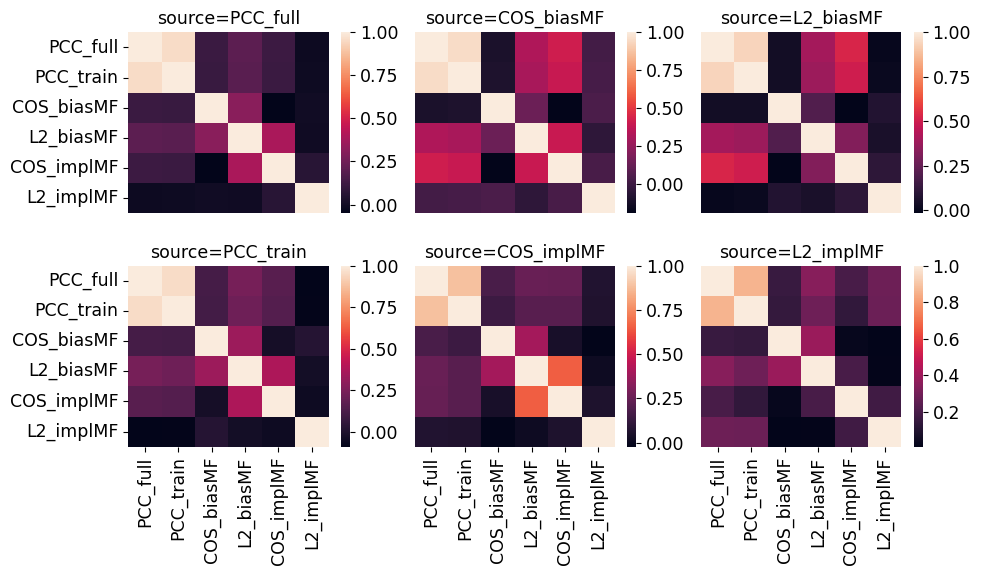

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_defaults()
increase_font_size()


fg, axs = plt.subplots(2,3, figsize=(10, 6))
g = sns.heatmap(
    result_dataframes["sim_full"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[0,0], xticklabels=False
)
g.set(title="source=PCC_full")

g = sns.heatmap(
    result_dataframes["sim_biased_mf_cos"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[0,1], xticklabels=False, yticklabels=False
)
g.set(title="source=COS_biasMF")


g = sns.heatmap(
    result_dataframes["sim_biased_mf_l2"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[0,2], xticklabels=False, yticklabels=False
)
g.set(title="source=L2_biasMF")


g = sns.heatmap(
    result_dataframes["sim_train"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[1,0]
)
g.set(title="source=PCC_train")

g = sns.heatmap(
    result_dataframes["sim_implicit_mf_cos"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[1,1], yticklabels=False
)
g.set(title="source=COS_implMF")


g = sns.heatmap(
    result_dataframes["sim_implicit_mf_l2"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[1,2], yticklabels=False
)
g.set(title="source=L2_implMF")


plt.tight_layout()
plt.show()
fg.savefig("./results/sim_correlations.pdf")

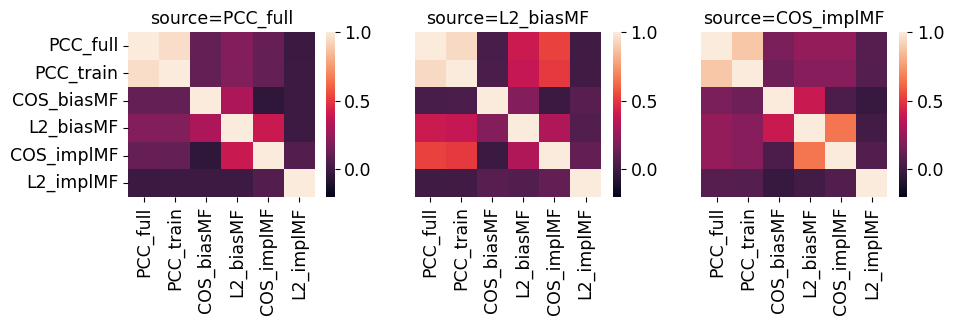

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_defaults()
increase_font_size()

cmap = None


fg, axs = plt.subplots(1,3, figsize=(10, 3.5))
g = sns.heatmap(
    result_dataframes["sim_full"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[0], cmap=cmap,  vmin=-0.2,vmax=1
)
g.set(title="source=PCC_full")

# g = sns.heatmap(result_dataframes["sim_biased_mf_cos"].corr(), ax=axs[0,1], xticklabels=False, yticklabels=False)
# g.set(title="source=sim_biased_mf_cos")


g = sns.heatmap(
    result_dataframes["sim_biased_mf_l2"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[1], yticklabels=False, cmap=cmap, vmin=-0.2,vmax=1
)
g.set(title="source=L2_biasMF")


# g = sns.heatmap(result_dataframes["sim_train"].corr(), ax=axs[1,0])
# g.set(title="source=sim_train")

g = sns.heatmap(
    result_dataframes["sim_implicit_mf_cos"].corr().rename(rename_d).rename(columns=rename_d),
    ax=axs[2], yticklabels=False, cmap=cmap,  vmin=-0.2,vmax=1
)
g.set(title="source=COS_implMF")


# g = sns.heatmap(result_dataframes["sim_implicit_mf_l2"].corr(), ax=axs[1,2], yticklabels=False)
# g.set(title="source=sim_implicit_mf_l2")


plt.tight_layout()
plt.show()
fg.savefig("./results/sim_correlations_small_camera_ready.pdf")

In [38]:
sim_full = sim_matrix_full
sim_train = sim_matrix_train
sim_bm = sim_matrix_biased_mf_l2

In [39]:
from sklearn.preprocessing import QuantileTransformer
sim_full_cdf = QuantileTransformer().fit(sim_full.reshape(-1, 1))
sim_bm_cdf = QuantileTransformer().fit(sim_bm.reshape(-1, 1))

In [40]:
cdfs = {
    "sim_full": sim_full_cdf,
    "sim_biased_mf_l2": sim_bm_cdf
}

In [41]:
### Comparing sim_full against sim_biased_mf

import time
from synthetic_groups_generation.groups_generators import Outliers

outlier_similarities = {}

result_dataframes = {}

outlier_mean_similarities = {}
outlier_mean_similarities_transformed = {}

dffs = []

for source_metric in ["sim_full", "sim_biased_mf_l2"]:

    outlier_mean_similarities[source_metric] = {}
    outlier_mean_similarities_transformed[source_metric] = {}
    
    grc = group_compositions[source_metric]
    
    sim_source = metrics[source_metric]
    
    for target_metric in ["sim_full", "sim_biased_mf_l2"]:
        outlier_mean_similarities[source_metric][target_metric] = []
        outlier_mean_similarities_transformed[source_metric][target_metric] = []
        sim_target = metrics[target_metric]
    
        for i in range(2400, 3600): # Take all similar_with_centered_outliers with all group sizes  #range(2400, 2600):
            grp = grc[i]
            grp_size = grp["group_size"]

            outs = Outliers.get_num_outliers(grp_size)

            outliers = grp["group_members"][:outs]
            not_outliers = grp["group_members"][outs:]

            for outlier in outliers:
                out_idx = id_to_idx[outlier]
                s = 0
                #s2 = 0
                for non_out in not_outliers:
                    non_out_idx = id_to_idx[non_out]
                    s += sim_target[out_idx, non_out_idx]
                    #s2 += sim_target[out_idx, non_out_idx]
                s /= len(not_outliers)
                #s2 /= len(not_outliers)
                outlier_mean_similarities[source_metric][target_metric].append(s)
                #outlier_mean_similarities[target_metric].append(s2)

                
        outlier_mean_similarities_transformed[source_metric][target_metric] = cdfs[target_metric].transform(np.array(outlier_mean_similarities[source_metric][target_metric]).reshape(-1, 1))
        
        dffs.append(
            pd.DataFrame({
            "mean_sim": np.squeeze(outlier_mean_similarities_transformed[source_metric][target_metric]),
            "source_metric": [source_metric] * 3600,
            "target_metric": [target_metric] * 3600
        }),
        )
        
dff = pd.concat(dffs)
dff

,mean_sim,source_metric,target_metric
0,0.004910,sim_full,sim_full
1,0.003950,sim_full,sim_full
2,0.004445,sim_full,sim_full
3,0.015731,sim_full,sim_full
4,0.015241,sim_full,sim_full
...,...,...,...
3595,0.209310,sim_biased_mf_l2,sim_biased_mf_l2
3596,0.256408,sim_biased_mf_l2,sim_biased_mf_l2
3597,0.535466,sim_biased_mf_l2,sim_biased_mf_l2
3598,0.237423,sim_biased_mf_l2,sim_biased_mf_l2


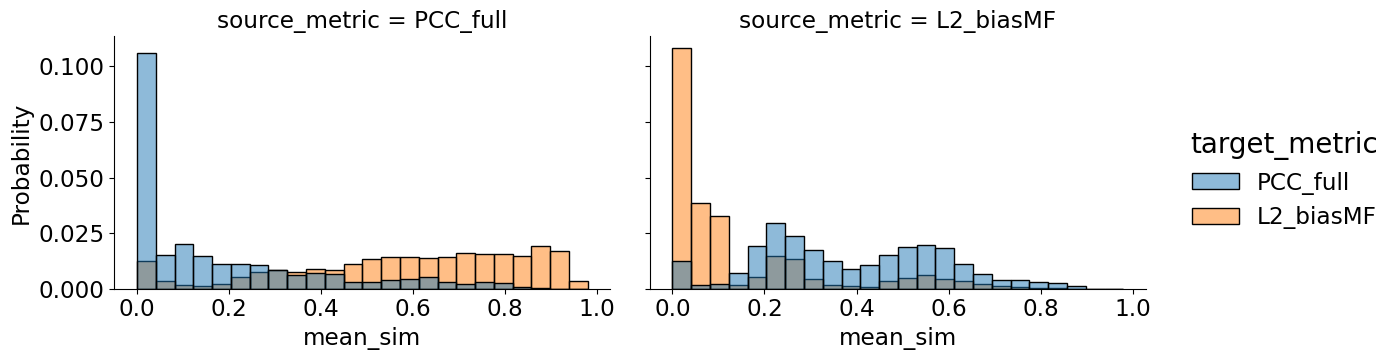

In [80]:
## New, should look same as below
import seaborn as sns
import matplotlib.pyplot as plt
sns.reset_defaults()
increase_font_size(2.0)
p = sns.displot(
    dff.replace(rename_d),
    x="mean_sim", stat="probability", common_norm=True, col="source_metric", hue="target_metric", height=4, aspect=1.5
)
plt.savefig("results/outlierDistance_camera_ready.pdf")
plt.show()